In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


In [2]:
def fillContours(binary):
    
    des,contour,hier = cv2.findContours(binary,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contour:
        cv2.drawContours(des,[cnt],0,255,-1)
    
    return des

In [7]:
# WATERSHED METHOD
# Foreground Background segmentation/Watershed Algorithm
img = cv2.imread('multiple_stamps_light_bg.jpg',1)

# grayscale
G = int(img.shape[0] * 0.0015)
if not G%2: G = G + 1
M = int(img.shape[1] * 0.0015)
if not M%2: M = M + 1
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(G,M),cv2.BORDER_DEFAULT)
blur = cv2.medianBlur(blur,3*M,cv2.BORDER_DEFAULT)
thresh = cv2.Canny(blur, 50, 100, True)

# Closing the holes in binary image
kernel = np.ones((G,G),np.uint8)
closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel, iterations = M)
# Finding the sure background area
opening = cv2.dilate(closing,kernel,iterations=M)
opening = fillContours(opening)
sure_bg = cv2.bitwise_not(opening)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(closing.astype(np.uint8),cv2.DIST_L2,G)
ret, sure_fg = cv2.threshold(dist_transform, 0.1*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(opening.astype(np.uint8),sure_fg)
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

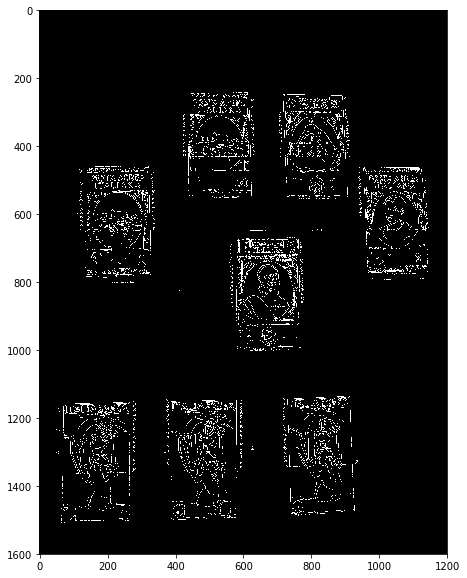

In [8]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(thresh, cmap='gray')

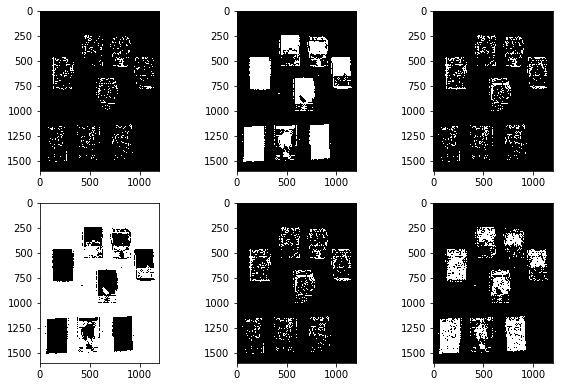

In [254]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(331)
plt.imshow(thresh, cmap='gray')
plt.subplot(332)
plt.imshow(opening, cmap='gray')
plt.subplot(333)
plt.imshow(closing, cmap='gray')
plt.subplot(334)
plt.imshow(sure_bg, cmap='gray')
plt.subplot(335)
plt.imshow(sure_fg, cmap='gray')
plt.subplot(336)
plt.imshow(unknown, cmap='gray')

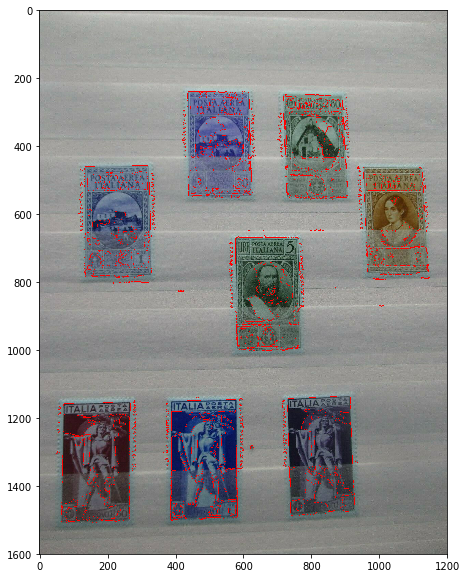

In [255]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(img)

In [37]:
# GRADIENTS METHOD
# Edge detection/Segmentation
img = cv2.imread('multiple_stamps_dark_bg.jpg',cv2.IMREAD_COLOR)

G = int(img.shape[0] * 0.0015)
if not G%2: G = G + 1
M = int(img.shape[1] * 0.0015)
if not M%2: M = M + 1
    
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(G,M),cv2.BORDER_DEFAULT)
blur = cv2.medianBlur(blur,3*M,cv2.BORDER_DEFAULT)

grad_x = cv2.Sobel(blur.astype('int16'), cv2.CV_16S,1,0,M,1,1)
grad_y = cv2.Sobel(blur.astype('int16'), cv2.CV_16S,0,1,M,1,1)
abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)

grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

ret, borders = cv2.threshold(grad, 0.05*grad.max(),255,0)
kernel = np.ones((G,G),np.uint8)
closing = cv2.morphologyEx(borders,cv2.MORPH_CLOSE,kernel, iterations = M)
closing = cv2.morphologyEx(closing,cv2.MORPH_OPEN,kernel, iterations = M)
fill = fillContours(closing)

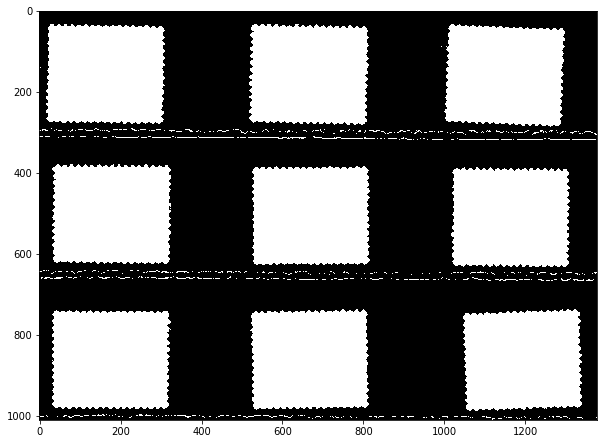

In [38]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(fill, cmap='gray')